In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [20]:
import yfinance as yf

# Define the ticker symbol for the S&P 500 index
ticker_symbol = "USDJPY=X"

# Define the desired date range for the historical data
start_date = "2003-07-04"
end_date = "2023-07-04"

# Download the historical data using yfinance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2003-07-04  118.169998  118.459999  118.099998  118.330002  118.330002       0
2003-07-07  118.099998  118.320000  117.809998  118.089996  118.089996       0
2003-07-08  118.110001  118.690002  117.589996  118.250000  118.250000       0
2003-07-09  118.290001  118.440002  117.599998  117.809998  117.809998       0
2003-07-10  117.790001  118.019997  117.339996  117.669998  117.669998       0
...                ...         ...         ...         ...         ...     ...
2023-06-27  143.460007  144.162994  143.292007  143.460007  143.460007       0
2023-06-28  143.882004  144.595001  143.735992  143.882004  143.882004       0
2023-06-29  144.389008  144.891998  144.138000  144.389008  144.389008       0
2023-06-30  144.779999  145.033005  144.227997  144.779999  14

In [21]:
data = data.loc[start_date:end_date]

# Extract the 'Close' prices for training
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [22]:
# Define the training and testing set sizes
train_size = int(len(scaled_close_prices) * 0.8)
test_size = len(scaled_close_prices) - train_size

# Split the data into training and testing sets
train_data = scaled_close_prices[:train_size, :]
test_data = scaled_close_prices[train_size:, :]

Create the LSTM model

In [23]:
# Define the number of previous time steps to consider for each prediction
n_steps = 80

# Create the training data by sliding the window of previous time steps
X_train, y_train = [], []
for i in range(n_steps, train_size):
    X_train.append(train_data[i-n_steps:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data to fit the LSTM model input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Train the LSTM model

In [24]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
128/128 [==============================] - 20s 118ms/step - loss: 0.0030
Epoch 2/20
128/128 [==============================] - 12s 95ms/step - loss: 4.5176e-04
Epoch 3/20
128/128 [==============================] - 13s 99ms/step - loss: 4.0858e-04
Epoch 4/20
128/128 [==============================] - 13s 102ms/step - loss: 3.6764e-04
Epoch 5/20
128/128 [==============================] - 13s 99ms/step - loss: 3.3542e-04
Epoch 6/20
128/128 [==============================] - 13s 100ms/step - loss: 3.0261e-04
Epoch 7/20
128/128 [==============================] - 13s 101ms/step - loss: 2.8796e-04
Epoch 8/20
128/128 [==============================] - 13s 103ms/step - loss: 2.8337e-04
Epoch 9/20
128/128 [==============================] - 13s 100ms/step - loss: 2.4656e-04
Epoch 10/20
128/128 [==============================] - 13s 105ms/step - loss: 2.4168e-04
Epoch 11/20
128/128 [==============================] - 13s 105ms/step - loss: 2.2507e-04
Epoch 12/20
128/128 [================

The reported loss value of `1.5717e-04` means that, on average, the squared difference between the predicted and actual values is very small. A lower loss value suggests that the model has learned to make more accurate predictions during the training process.

Make predictions on the test data

In [25]:
# Create the test data by sliding the window of previous time steps
X_test, y_test = [], []
for i in range(n_steps, test_size):
    X_test.append(test_data[i-n_steps:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data to fit the LSTM model input shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predicted values
predictions = scaler.inverse_transform(predictions)

30/30 [==============================] - 2s 30ms/step


In [26]:
# Create a dataframe for the predicted values
predictions_df = pd.DataFrame(predictions, columns=['Predicted'], index=data.index[train_size+n_steps:train_size+n_steps+test_size])

# Create a dataframe for the actual values
actual_df = pd.DataFrame(data['Close'].values[train_size+n_steps:train_size+n_steps+test_size], columns=['Actual'], index=data.index[train_size+n_steps:train_size+n_steps+test_size])

# Concatenate the predicted and actual values dataframes
result_df = pd.concat([predictions_df, actual_df], axis=1)

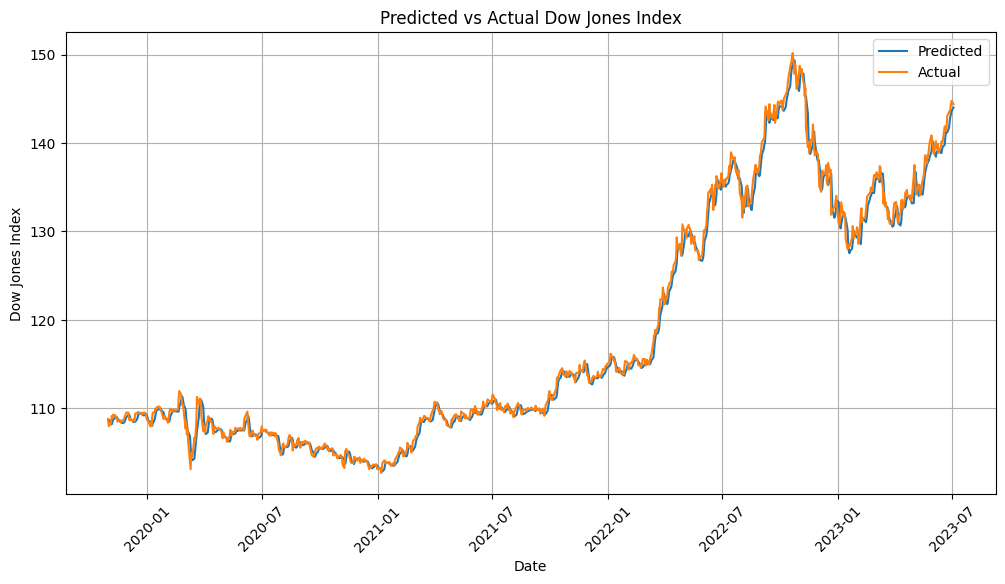

In [27]:
# Plotting the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Predicted'], label='Predicted')
plt.plot(result_df.index, result_df['Actual'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Dow Jones Index')
plt.title('Predicted vs Actual Dow Jones Index')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [28]:
# Extract the close prices for the entire dataset
close_prices_full = data['Close'].values.reshape(-1, 1)

# Normalize the full data
scaled_close_prices_full = scaler.transform(close_prices_full)

# Create the input data for forecasting by including the last n_steps values from the full data
X_forecast = scaled_close_prices_full[-n_steps:]

# Reshape the input data to fit the LSTM model input shape
X_forecast = np.reshape(X_forecast, (1, n_steps, 1))


In [29]:
# Define the number of forecast steps
n_forecast_steps = 10

# Initialize an empty list to store the forecasted values
forecast_predictions = []

# Reshape the input data to fit the LSTM model input shape
X_forecast = np.reshape(X_forecast, (1, n_steps, 1))

# Generate multiple predictions for the forecast period
for _ in range(n_forecast_steps):
    # Make a prediction for the next timestep
    forecast = model.predict(X_forecast)

    # Append the forecasted value to the list
    forecast_predictions.append(forecast[0, 0])

    # Update the input sequence by shifting it and adding the new forecasted value at the end
    X_forecast = np.roll(X_forecast, -1, axis=1)
    X_forecast[0, -1, 0] = forecast

    # Reshape the input data for the next prediction
    X_forecast = np.reshape(X_forecast, (1, n_steps, 1))

# Inverse transform the forecasted values
forecast_predictions = scaler.inverse_transform(np.array(forecast_predictions).reshape(-1, 1))

# Create the forecasted date range
forecast_dates = pd.date_range(start='2023-07-05', periods=n_forecast_steps, freq='D')

# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(forecast_predictions, columns=['Forecast'], index=forecast_dates)

# Print the forecasted values
print(forecast_df)

1/1 [==============================] - 0s 32ms/step
              Forecast
2023-07-05  144.046982
2023-07-06  143.777939
2023-07-07  143.419342
2023-07-08  143.055832
2023-07-09  142.720184
2023-07-10  142.419830
2023-07-11  142.150055
2023-07-12  141.901337
2023-07-13  141.663574
2023-07-14  141.428253


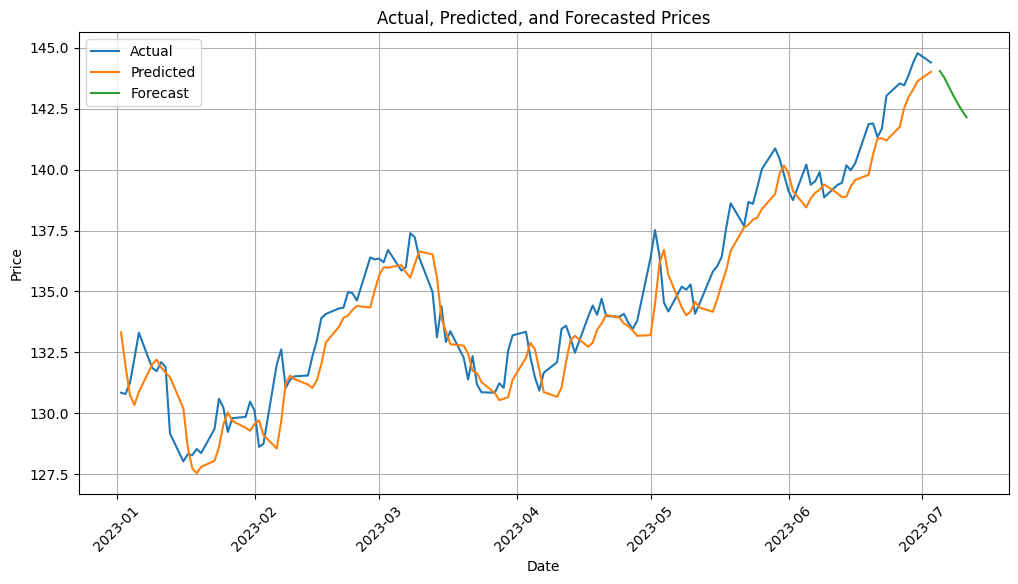

In [30]:
# Define the start and end dates for the plot
plot_start_date = '2023-01-01'
plot_end_date = '2023-07-11'

# Filter the result dataframe for the desired date range
plot_data = result_df.loc[plot_start_date:plot_end_date]

# Filter the forecast dataframe for the desired date range
plot_forecast = forecast_df.loc[plot_start_date:plot_end_date]

# Plot the actual, predicted, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Actual'], label='Actual')
plt.plot(plot_data.index, plot_data['Predicted'], label='Predicted')
plt.plot(plot_forecast.index, plot_forecast['Forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual, Predicted, and Forecasted Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()